# Implementation of SARSA On-Policy TD Control on FrozenLake-v1

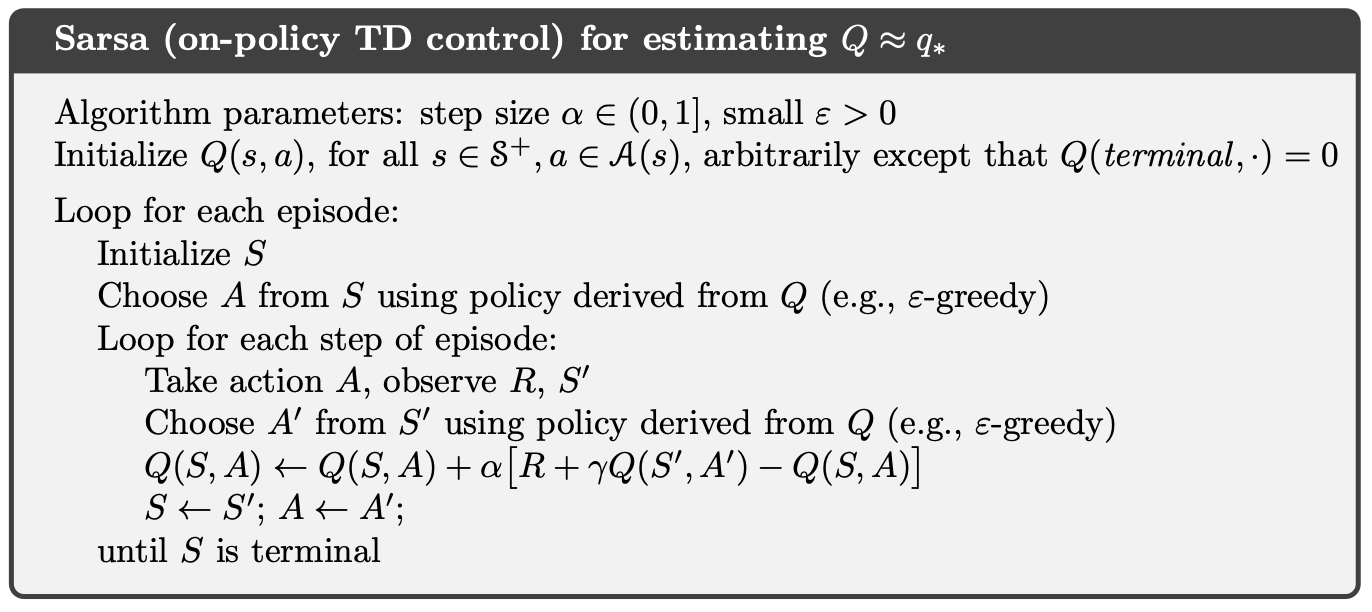

In [3]:
import gym
import numpy as np

# Parameters
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, render_mode="human")
nS = env.observation_space.n 
nA = env.action_space.n 
gamma = 0.8
alpha = 0.1
epsilon = 0.1
maxEpisodes = 100

# Initialization
Q = np.zeros([nS, nA])

# Looping Forever
for episode in range(maxEpisodes):
    initialState, _ = env.reset()
    initialAction = None
    if np.random.random() < epsilon:
        initialAction = np.random.randint(low=0, high=nA-1)
    else:
        initialAction = np.random.choice(np.where(Q[initialState] == Q[initialState].max())[0]) # np.argmax only gives first index of item if there is a tie in max, need to utilize this to ensure that we randomize the action being chosen if the Q values are the same

    done = False
    currentEpisode = 0
    while not done:
        nextState, reward, done, _, _ = env.step(initialAction)

        nextAction = None
        if np.random.random() < epsilon:
            nextAction = np.random.randint(low=0, high=nA-1)
        else:
            nextAction = np.random.choice(np.where(Q[nextState] == Q[nextState].max())[0])

        # If the agent is still on ice, then give penalty for not finding the treasure.
        if reward == 0:
            reward = -0.001
        
        # If the agent falls into the hole, give a large penalty
        if done and nextState != 15:
            reward = -1
        
        # If agent took too long, penalize
        if currentEpisode == 100:
            done = True
            reward = -1
        
        # Penalize if agent doesnt move
        if initialState == nextState:
            reward = -1

        Q[initialState][initialAction] = Q[initialState][initialAction] + alpha * (reward + (gamma * Q[nextState][nextAction]) - Q[initialState][initialAction])
        initialState = nextState
        initialAction = nextAction
        currentEpisode += 1


# Policy Visualization

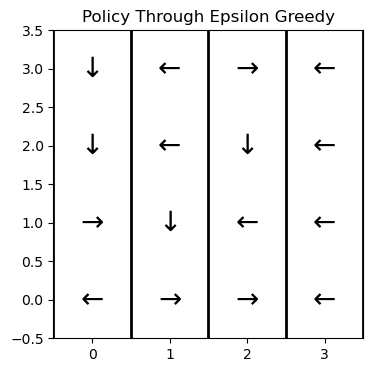

In [14]:
# Visualize the Policy
import matplotlib.pyplot as plt

def actionToArrow(action):
    if action == 0:
        return '←'
    elif action == 1:
        return '↓'
    elif action == 2:
        return '→'
    elif action == 3:
        return '↑'

nrow, ncol = 4, 4

fig, ax = plt.subplots(figsize=(ncol, nrow))
ax.set_xticks(np.arange(ncol+1)-0.5, minor=True)
ax.set_yticks(np.arange(nrow+1)-0.5, minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)
ax.set_xlim(-0.5, ncol-0.5)
ax.set_ylim(-0.5, nrow-0.5)
ax.set_title("Policy Through Epsilon Greedy")
for i in range(nrow):
    for j in range(ncol):
        action = np.argmax(Q[i*ncol + j])
        arrow = actionToArrow(action)
        ax.text(j, nrow-1-i, arrow, ha='center', va='center', fontsize=20)
plt.show()
env.close()

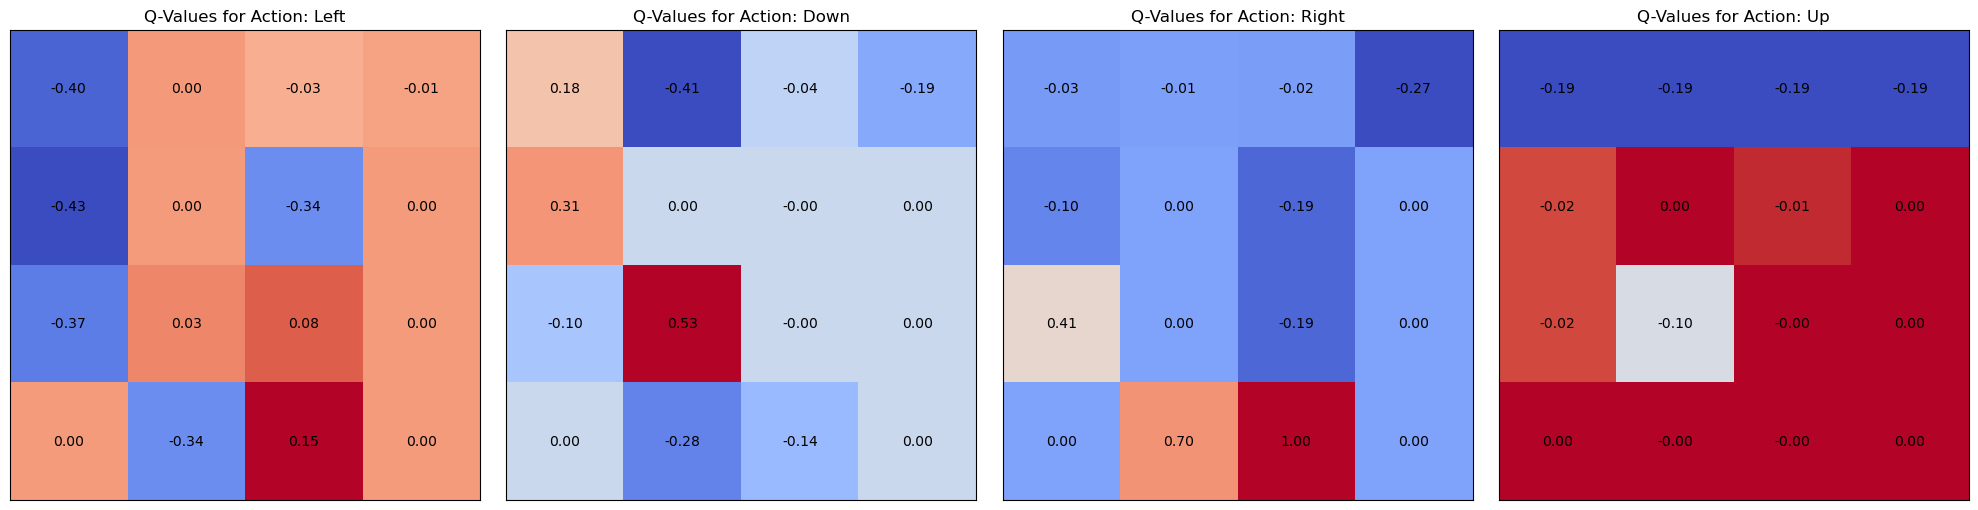

In [5]:
# Visualize the Policy
import matplotlib.pyplot as plt

# Visualize State Values as a Heatmap
fig, axes = plt.subplots(1, nA, figsize=(20, 5))
actions = ["Left", "Down", "Right", "Up"]

for i in range(nA):
    Q_action = Q[:, i].reshape((4, 4))
    ax = axes[i]
    cax = ax.matshow(Q_action, cmap="coolwarm")
    for (j, k), val in np.ndenumerate(Q_action):
        ax.text(k, j, f'{val:.2f}', ha='center', va='center', color='black')
    ax.set_title(f'Q-Values for Action: {actions[i]}')
    ax.set_xticks([])
    ax.set_yticks([])

# fig.colorbar(cax, ax=axes, orientation='vertical', fraction=0.025, pad=0.04)
plt.tight_layout()
plt.show()

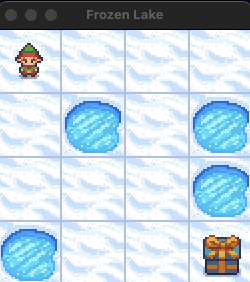

This is the layout of the map.
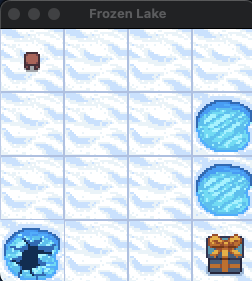

## Expected SARSA vs SARSA
Just like Q-Learning, instead of taking the maximum over next state-action pairs Expected SARSA takes the expected value. This the new update rule:

$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \mathbb{E}_\pi \left[ Q(S_{t+1}, A_{t+1}) \mid S_{t+1} \right] - Q(S_t, A_t) \right] $

$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[ R_{t+1} + \gamma \sum_a \pi(a \mid S_{t+1}) Q(S_{t+1}, a) - Q(S_t, A_t) \right]$

Expected Sarsa is more complex computationally than Sarsa, but in returns eliminates the variance due to the random selection of $A_{t+1}$
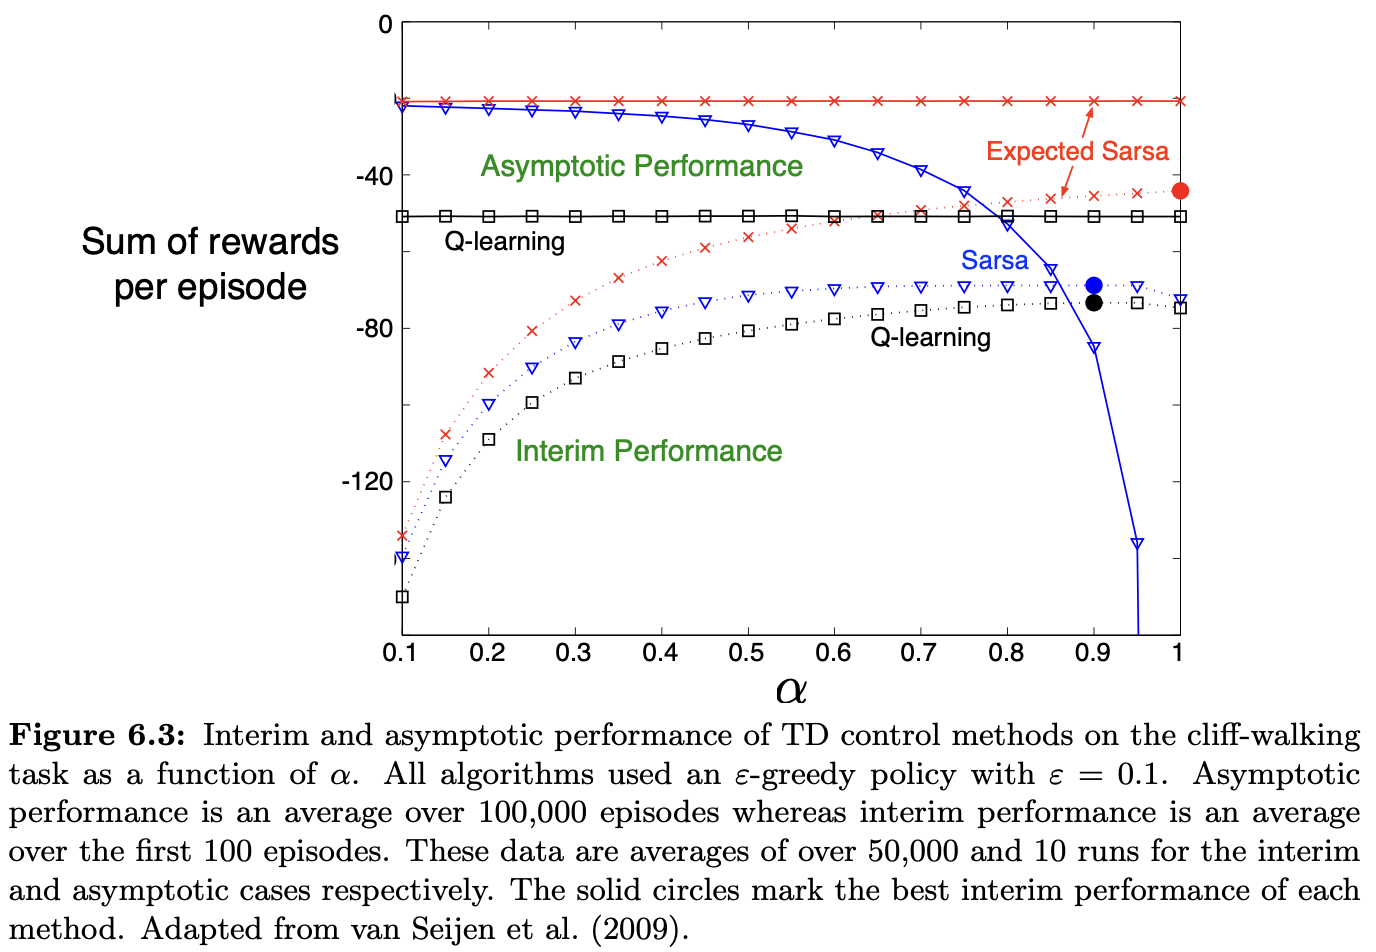